# Black and White image colorization

## Loading files

In [1]:
RESET_PROJECT_FILES = True

if RESET_PROJECT_FILES:
  ! rm -rf DeepColor utils bash &&\
  git clone https://github.com/ArnoBen/DeepColor &&\
  mv DeepColor/* . &&\
  rm -rf DeepColor

Cloning into 'DeepColor'...
remote: Enumerating objects: 237, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 237 (delta 56), reused 71 (delta 29), pack-reused 137
Receiving objects: 100% (237/237), 172.63 MiB | 15.46 MiB/s, done.
Resolving deltas: 100% (112/112), done.


## Data exploration and preprocessing

In [2]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from utils.conversions import bgr2rgb, rgb2lab, lab2rgb, bgr2lab
from utils.models import get_model
from utils.decomposition import decompose, decompose_generator, recompose
from utils.dataset import make_dataset
from glob import glob
from itertools import chain
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
import matplotlib
matplotlib.rcParams["axes.spines.left"] = False
matplotlib.rcParams["axes.spines.bottom"] = False
matplotlib.rcParams["xtick.major.bottom"] = False
matplotlib.rcParams["ytick.major.left"] = False

np.random.seed(42)

In [15]:
#dataset
! gdown 1GtxNs-zIxypHCYD88_gG2Gf2KE7AvU-L

Downloading...
From: https://drive.google.com/uc?id=1GtxNs-zIxypHCYD88_gG2Gf2KE7AvU-L
To: /content/coco256.7z
100% 1.13G/1.13G [00:05<00:00, 214MB/s]


In [16]:
! 7z x coco256.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1133731977 bytes (1082 MiB)

Extracting archive: coco256.7z
--
Path = coco256.7z
Type = 7z
Physical Size = 1133731977
Headers Size = 214910
Method = Copy
Solid = -
Blocks = 25018

  0%      3% 928          7% 1868          11% 2778          14% 3644 - images/test/40000/000000107224.jpg                                               17% 4517          21% 5364 - images/train/02000/000000082223.jpg                                                24% 6090 - image

# Full model

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, RepeatVector, Reshape, concatenate, UpSampling2D, MaxPooling2D
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from skimage.transform import resize
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## Create the Model

In [4]:
#Load weights
inception = InceptionResNetV2(weights=None, include_top=True)
inception.load_weights('weights/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5')
inception.graph = tf.compat.v1.get_default_graph()

embed_input = Input(shape=(1000,))

In [5]:
#Encoder
encoder_input = Input(shape=(256, 256, 1,))

encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_input)
encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
encoder_output = Conv2D(128, (4,4), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

In [6]:
#Fusion
fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)

In [7]:
#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (4,4), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(32, (2,2), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)


model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)


In [8]:
model.compile(optimizer='adam', loss='mae')

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 256, 256, 12  1280        ['input_4[0][0]']                
                                8)                                                                
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 128, 128, 12  0          ['conv2d_203[0][0]']             
                                8)                                                            

## Data Generator Functions¶

In [29]:
# Image transformer
# datagen = ImageDataGenerator(
#         shear_range=0.2,
#         zoom_range=0.2,
#         rotation_range=20,
#         horizontal_flip=True)

#Create embedding
def create_inception_embedding(grayscaled_rgb):
    def resize_gray(x):
        return resize(x, (299, 299, 3), mode='constant')
    grayscaled_rgb_resized = np.array([resize_gray(x) for x in grayscaled_rgb])
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)

    embed = inception.predict(grayscaled_rgb_resized, verbose=0)
    return embed

#Generate training data
# def image_a_b_gen(dataset, batch_size = 20):
#     for batch in datagen.flow(dataset, batch_size=batch_size):
#         X_batch = rgb2gray(batch)
#         grayscaled_rgb = gray2rgb(X_batch)
#         lab_batch = rgb2lab(batch)
#         X_batch = lab_batch[:,:,:,0]
#         X_batch = X_batch.reshape(X_batch.shape+(1,))
#         Y_batch = lab_batch[:,:,:,1:] / 128
#         yield [X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch

In [30]:
def preprocessing(image):
    image = np.array(image, dtype=np.uint8)
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB) / 255
    return lab_image


def custom_generator(data_generator):
    n = data_generator.samples
    batch_size = data_generator.batch_size
    end_index = n - n % batch_size
    while True:
        batch = data_generator.next()
        L_batch = batch[..., 0][..., np.newaxis]
        ab_batch = batch[..., 1:]
        grayscale_3d = np.concatenate([L_batch, L_batch, L_batch], axis=-1)
        yield [L_batch, create_inception_embedding(grayscale_3d)], ab_batch

Found 16346 images belonging to 19 classes.
Found 4329 images belonging to 5 classes.


In [32]:
for i, imgs in enumerate(custom_generator(train_data)):
  input, target = imgs
  L_batch, embed = input
  print(L_batch.shape, embed.shape, target.shape)
  if i == 0:
    break


(32, 256, 256, 1) (32, 1000) (32, 256, 256, 2)


## Checkpoints

In [44]:
def compare_output():
  for i, Lab in enumerate(custom_generator(valid_data)):
    input, ab = imgs
    L, embed = input
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    ab_pred = model.predict(input)
    
    img = np.concatenate((L[0], ab[0]), axis=-1)
    img_pred = np.concatenate((L[0], ab_pred[0]), axis=-1)

    img = (img * 255).astype(np.uint8)
    img_pred = (img_pred * 255).astype(np.uint8)
    
    axes[0].imshow(L[0, :, :, 0], cmap='gray')
    axes[1].imshow(cv2.cvtColor(img, cv2.COLOR_LAB2RGB))
    axes[2].imshow(cv2.cvtColor(img_pred, cv2.COLOR_LAB2RGB))
    plt.show()
    if i == 0:
      break

class GenerateImageCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(GenerateImageCallback, self).__init__()

    def on_epoch_end(self, epoch, logs=None):
        compare_output()

In [47]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5,
                                            min_lr=0.00001)
filepath = "Art_Colorization_Model.h5"

checkpoint = ModelCheckpoint(filepath,
                             save_best_only=True,
                             monitor='loss',
                             mode='min')

model_callbacks = [learning_rate_reduction, checkpoint, GenerateImageCallback()]

## Train the Model

In [34]:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    preprocessing_function = preprocessing
    )

BATCH_SIZE = 32

train_data = datagen.flow_from_directory("images/train/", 
                                         class_mode=None, target_size=(256, 256), batch_size=BATCH_SIZE)
valid_data = datagen.flow_from_directory("images/valid/", 
                                         class_mode=None, target_size=(256, 256), batch_size=BATCH_SIZE)

Found 16346 images belonging to 19 classes.
Found 4329 images belonging to 5 classes.


Epoch 1/20
1/1 [==============================] - 0s 22ms/step


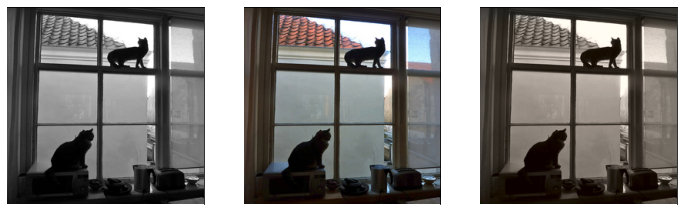

511/511 [==============================] - 703s 1s/step - loss: 0.0431 - val_loss: 0.0424 - lr: 0.0010
Epoch 2/20
468/511 [==========================>...] - ETA: 47s - loss: 0.0426

In [ ]:
model.fit(custom_generator(train_data),
          steps_per_epoch=len(train_data),
          validation_data=custom_generator(valid_data),
          validation_steps=len(valid_data),
          epochs=20,
          verbose=1,
          callbacks=model_callbacks
          )

1/1 [==============================] - 0s 23ms/step


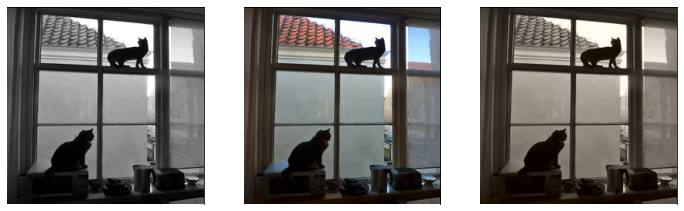

In [45]:
compare_output()